In [1]:
%matplotlib inline

In [2]:
from matplotlib.pylab import *

In [3]:
repo = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master"
style.use("results/style_sheet.mplstyle")

rc('figure', figsize=(8, 4))
rc('savefig', bbox='tight')
plt.rcParams.update({'font.size': 16})

import numpy as np

In [4]:
import torch
import torch.nn as nn
from models import resnet18_narrow as resnet18
from utils import get_loader
from utils.train_utils import AverageMeter, accuracy
import argparse
from sklearn.model_selection import ParameterGrid
import pickle
from tqdm import tqdm 
from sklearn.model_selection import ParameterGrid
import copy
import glob
import numpy as np
import scipy

param_grid = {'mo': [0.0, 0.5, 0.9],  # momentum
              'wd': [0.0, 1e-4, 5e-4],  # weight decay
              'lr': [7e-3, 0.0085, 1e-2],  # learning rate
              'bs': [32, 128, 512],  # batch size
              }

measure, momentum, weight decay, learning rate, batch size
eps_flat & -0.756 & -0.045 & -0.388 & 0.807 & 0.383
pac_bayes & -0.924 & -0.049 & -0.058 & 0.919 & 0.654
fro_norm & -0.928 & -0.454 & -0.609 & 0.931 & 0.536
fim & -0.758 & 0.831 & -0.366 & 0.664 & 0.227
eig_trace & -0.947 & -0.610 & -0.613 & 0.945 & 0.564
local_entropy & -0.563 & 0.996 & -0.154 & 0.589 & 0.341
low_pass & -0.952 & -0.997 & -0.962 & 0.956 & 0.715


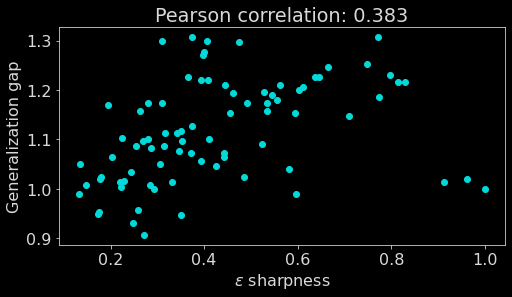

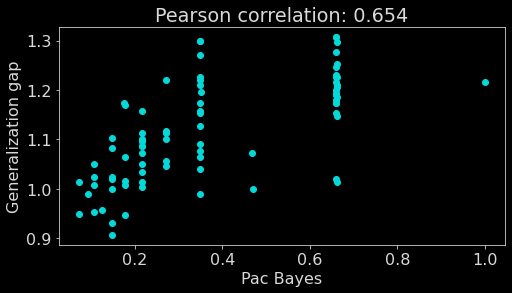

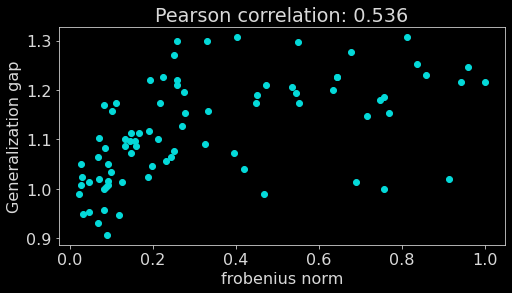

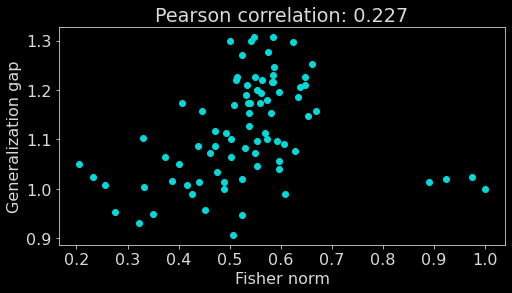

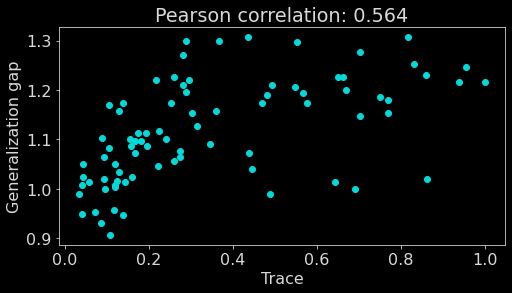

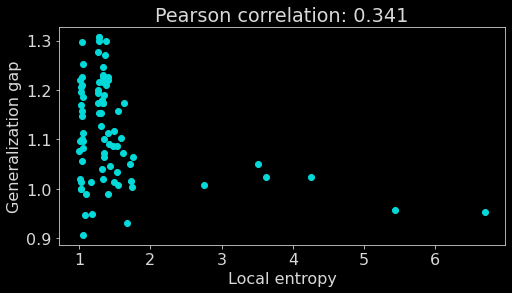

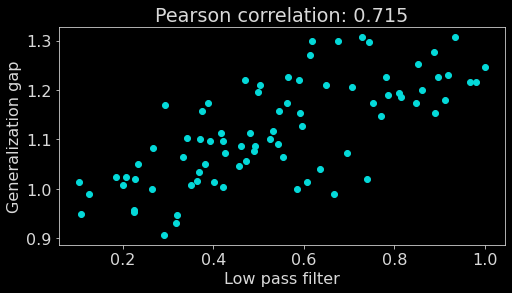

In [6]:
print(f"measure, momentum, weight decay, learning rate, batch size")
idx = 0
labels = ["$\epsilon$ sharpness", "Pac Bayes", "frobenius norm", "Fisher norm", "Trace", "Local entropy", "Low pass filter"]
for meas in ["eps_flat", "pac_bayes", "fro_norm", "fim", "eig_trace", "local_entropy", "low_pass"]:
    print(f"{meas} & ", end='')
    for key, value in param_grid.items():
        grid = copy.deepcopy(param_grid)
        del grid[key]
        
        grid = list(ParameterGrid(grid))
        corr = []
        for params in grid:
            flat_measure = []
            hyper_param = []
            for v in value:
                params[f"{key}"] = v
                name = f"checkpoints/mnist/lenet/" \
                       f"*_0_{params['mo']}_{params['wd']}" \
                       f"_{params['lr']}_{params['bs']}_{False}"

                fol = glob.glob(name)[0]

                with open(f"{fol}/run_ms_0/measures.pkl", 'rb') as f:
                    measures = pickle.load(f)

                if np.nan in list(measures.values()):
                    continue

                if measures['train_acc'] < 90:
                    continue

                flat_measure.append(measures[meas])
                if v is True:
                    hyper_param.append(1)
                elif v is False:
                    hyper_param.append(0)
                else:
                    hyper_param.append(v)
            corr.append(scipy.stats.pearsonr(hyper_param, flat_measure)[0])

        print(f"{np.mean(corr):0.3f} & ", end='')
    grid = list(ParameterGrid(param_grid))
    
    flat_measure = []
    gen_gap = []

    for params in grid:
        name = f"checkpoints/mnist/lenet/" \
               f"*_0_{params['mo']}_{params['wd']}" \
               f"_{params['lr']}_{params['bs']}_{False}"

        fol = glob.glob(name)[0]
        with open(f"{fol}/run_ms_0/measures.pkl", 'rb') as f:
            measures = pickle.load(f)

        flat_measure.append(measures[meas])
        gen_gap.append((100 - measures["val_acc"]) - (100 - measures["train_acc"]))
    
    print(f"{scipy.stats.pearsonr(gen_gap, flat_measure)[0]:0.3f}")
    fig, ax = plt.subplots()
    ax.scatter([f/np.max(flat_measure) for f in flat_measure], gen_gap)
    ax.set_xlabel(f"{labels[idx]}")
    idx+=1
    ax.set_ylabel("Generalization gap")
    ax.set_title(f"Pearson correlation: {scipy.stats.pearsonr(gen_gap, flat_measure)[0]:0.3f}")
    fig.savefig(f"results/deep_learning/lenet_mnist/figure_{labels[idx-1]}.png")

In [5]:
# same results as fantastic papers

print(f"measure, momentum, weight decay, learning rate, batch size")
# pick a measure
for meas in ["eps_flat", "pac_bayes", "fro_norm", "fim", "eig_trace", "local_entropy", "low_pass"]:
    print(f"{meas} & ", end='')
    # pick a hyper-parameter
    for key, value in param_grid.items():
        grid = copy.deepcopy(param_grid)
        del grid[key]
        
        grid = list(ParameterGrid(grid))
        corr = []
        # loop over all other set of hyper-parameters
        for params in grid:
            flat_measure = []
            gen_gap = []
            # and just vary a single hyper-parameter that we picked
            for v in value:
                params[f"{key}"] = v
                name = f"checkpoints/mnist/lenet/" \
                       f"*_0_{params['mo']}_{params['wd']}" \
                       f"_{params['lr']}_{params['bs']}_{False}"

                fol = glob.glob(name)[0]

                with open(f"{fol}/run_ms_0/measures.pkl", 'rb') as f:
                    measures = pickle.load(f)
                
                # record flatness and gen_gap for it
                flat_measure.append(measures[meas])
                gen_gap.append((100 - measures["val_acc"]) - (100 - measures["train_acc"]))
            # compute tau and append (this is inner tau in equation 4 of fantastic)
            # just that our tau is not kendall but pearson
            corr.append(scipy.stats.kendalltau(gen_gap, flat_measure)[0])

        # this is mean over a picked hyper-parameter
        print(f"{np.mean(corr):0.3f} & ", end='')
    print(' ')

print("Empirical order & ", end=' ')
# pick a hyper-parameter
for key, value in param_grid.items():
    grid = copy.deepcopy(param_grid)
    del grid[key]

    grid = list(ParameterGrid(grid))
    corr = []
    # loop over all other set of hyper-parameters
    for params in grid:
        gen_gap = []
        hyp = []
        # and just vary a single hyper-parameter that we picked
        for v in value:
            params[f"{key}"] = v
            name = f"checkpoints/mnist/lenet/" \
                   f"*_0_{params['mo']}_{params['wd']}" \
                   f"_{params['lr']}_{params['bs']}_{False}"

            fol = glob.glob(name)[0]

            with open(f"{fol}/run_ms_0/measures.pkl", 'rb') as f:
                measures = pickle.load(f)

            # record flatness and hyper-parameter for it
            gen_gap.append((100 - measures["val_acc"]) - (100 - measures["train_acc"]))
            hyp.append(v)

        # compute tau and append (this is inner tau in equation 4 of fantastic)
        # just that our tau is not kendall but pearson
        corr.append(scipy.stats.kendalltau(hyp, gen_gap)[0])

    # this is mean over a picked hyper-parameter
    print(f"{np.mean(corr):0.3f} & ", end='')

measure, momentum, weight decay, learning rate, batch size
eps_flat & 0.266 & -0.086 & -0.051 & 0.432 &  
pac_bayes & 0.395 & 0.062 & 0.073 & 0.506 &  
fro_norm & 0.562 & 0.012 & 0.048 & 0.605 &  
fim & 0.414 & -0.136 & 0.086 & 0.457 &  
eig_trace & 0.562 & -0.037 & 0.048 & 0.605 &  
local_entropy & 0.340 & -0.136 & 0.081 & 0.457 &  
low_pass & 0.562 & 0.136 & 0.215 & 0.605 &  
Empirical order &  -0.562 & -0.136 & -0.235 & 0.605 & 

In [ ]:
glob.glob(name)